# Multiple Linear Regression

Multiple Linear Regression attempts to model the relationship between two or more features and a response by fitting a linear equation to observed data.  For example, in this notebook, predicting Co2 emission using
EngineSize and the number of Cylinders in the car’s engine.

There are two applications for multiple linear regression:

1) It can be used when we would like to identify the strength of the effect that the
independent variables have on a dependent variable.

2) It can be used to predict the impact
of changes. That is, to understand how the dependent variable
changes when we change the independent variables.

What we use for multiple linear regression is to find the best fit hyper-plane for our data. To this end we should estimate the values
for coefficient vector that best predict the value of the target field in each row. To achieve this goal, we have to minimize the error of the prediction. To minimize it, we could find the best parameters by using Least Squares or an optimization algorithm  like Gradient Descent.

Let's start by importing needed libraries: 

## Importing packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

## Downloading Data

In [3]:
!wget -O FuelConsumption.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv

--2024-01-30 17:08:50--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv
Resolviendo cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Conectando con cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)[169.63.118.104]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 72629 (71K) [text/csv]
Guardando como: ‘FuelConsumption.csv’

FuelConsumption.csv 100%[===================>]  70,93K  77,0KB/s    en 0,9s    

2024-01-30 17:08:52 (77,0 KB/s) - ‘FuelConsumption.csv’ guardado [72629/72629]



## Understanding th Data

We have downloeaded a fuel cosnumption dataset, FuelCosnumption.csv, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. 

Source: https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64



- MODELYEAR e.g. 2014
- MAKE e.g. Acura
- MODEL e.g. ILVEHICLE CLASS e.g. SUV
- ENGINE SIZE e.g. 4.7
- CYLINDERS e.g 6
- TRANSMISSION e.g. A6
- FUELTYPE e.g. z
- FUEL CONSUMPTION in CITY(L/100 km) e.g. 9.9
- FUEL CONSUMPTION in HWY (L/100 km) e.g. 8.9
- FUEL CONSUMPTION COMB (L/100 km) e.g. 9.2
- CO2 EMISSIONS (g/km) e.g. 182 --> low --> 0


## Reading the data 

In [6]:
df = pd.read_csv("FuelConsumption.csv")
 # let's see the first five rows of the dataset
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [7]:
# In this case, We only are going to consider the next rows:  ENGINESIZE , CYLINDERS, FUELCONSUMPTION_CITY, FUELCONSUMPTION_HWY , FUELCONSUMPTION_COMB, CO2EMISSIONS 
# to analyze some interesting correlation:

cdf = df[['ENGINESIZE', 'CYLINDERS' , 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY' , 'FUELCONSUMPTION_COMB', 'CO2EMISSIONS']]
cdf.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,196
1,2.4,4,11.2,7.7,9.6,221
2,1.5,4,6.0,5.8,5.9,136
3,3.5,6,12.7,9.1,11.1,255
4,3.5,6,12.1,8.7,10.6,244


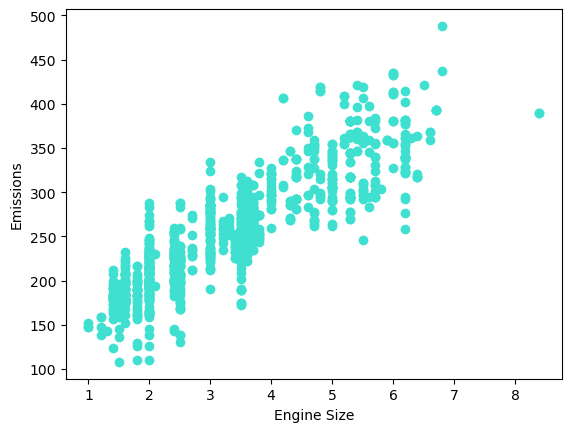

In [8]:
# Let's plot Emission values with respect to Engine size: 
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS, color='turquoise')
plt.xlabel("Engine Size")
plt.ylabel("Emissions")
plt.show()

### Creating train and test dataset

Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the np.random.rand() function: 

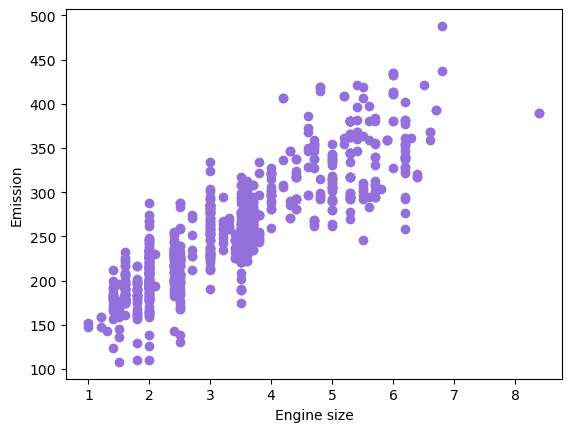

In [9]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

# Train data distribution
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS, color='mediumpurple')
plt.xlabel('Engine size')
plt.ylabel('Emission')
plt.show()

## Multiple Regression model

In reality, there are multiple variables that impact the co2emission. When more than one independent variable is present, the process is called multiple linear regression. An example of multiple linear regression is predicting co2emission using the features FUELCONSUMPTION_COMB, EngineSize and Cylinders of cars. The good thing here is that multiple linear regression model is the extension of the simple linear regression model.


In [11]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit(x,y)
print('Coefficients:', regr.coef_)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Coefficients: [[11.18967773  7.22934984  9.72831221]]


## Prediction

In [12]:
y_hat = regr.predict(test[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']])
x = np.asanyarray(test[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']])
y = np.asanyarray(test[['CO2EMISSIONS']])
print("Residual sum of squares: %.2f"% np.mean((y_hat - y)**2))
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 522.67
Variance score: 0.87


/home/andy/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Explained variance regression score:

Let 𝑦̂  be the estimated target output, y the corresponding (correct) target output, and Var be the Variance (the square of the standard deviation). Then the explained variance is estimated as follows:

𝚎𝚡𝚙𝚕𝚊𝚒𝚗𝚎𝚍𝚅𝚊𝚛𝚒𝚊𝚗𝚌𝚎(𝑦,𝑦̂ )=1−𝑉𝑎𝑟{𝑦−𝑦̂ }𝑉𝑎𝑟{𝑦}

The best possible score is 1.0, the lower values are worse.